<a href="https://colab.research.google.com/github/etgins/weapon_detection_with_transfer_learning/blob/main/DL_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
# !git clone https://github.com/ultralytics/yolov5

In [85]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from tqdm import tqdm
import random
from sklearn.model_selection import train_test_split
import shutil
from torch.utils.data import DataLoader, Dataset
import time
import copy
import cv2
import tensorflow as tf


# %matplotlib notebook
%matplotlib inline

import xml.etree.ElementTree as ET

seed = 212
np.random.seed(seed)
torch.manual_seed(seed)

from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Colab Notebooks/046211_Deep_Learning/DL_project'



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/046211_Deep_Learning/DL_project


# Sources
⭐1. training yolo v5 on a custom dataset: https://blog.paperspace.com/train-yolov5-custom-data/
2. pytorch data loading tutorial: https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/21adbaecd47a412f8143afb1c48f05a6/data_loading_tutorial.ipynb#scrollTo=6S5I0VfvBsPq
3. pytorch transfer learning for CV: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html?highlight=transfer_learning_tutorial
4. pytorch YOLOv5 tutorial: https://colab.research.google.com/github/ultralytics/yolov5/blob/master/tutorial.ipynb#scrollTo=7mGmQbAO5pQb


# Load model, freeze layers
----

In [ ]:
# model = torchvision.models.detection.mask_rcnn(pretrained=False, progress=True, num_classes=91, pretrained_backbone=True, trainable_backbone_layers=None, **kwargs)
# model = torchvision.models.googlenet(pretrained = True, progress=True)
# model.eval()

# YOLO V5 model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True, classes=2)
print(model)

In [ ]:
model.eval()

# show model layers
# for k, v in model.named_parameters():
#     print(k)

# Freeze 
freeze = 23
freeze = [f'model.{x}.' for x in range(freeze)]  # layers to freeze 
for k, v in model.named_parameters(): 
    v.requires_grad = True  # train all layers 
    if any(x in k for x in freeze): 
        # print(f'freezing {k}') 
        v.requires_grad = False 
    else:
      print(f'not freezing {k}') 

# Dataset helper functions
extract data from xml, convert to YOLOv5 format


In [20]:
# Function to get the data from XML Annotation

def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()
    
    # Initialise the info dict 
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name 
        if elem.tag == "filename":
            info_dict['filename'] = elem.text
            
        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))
            
            info_dict['image_size'] = tuple(image_size)
        
        # Get details of the bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)            
            info_dict['bboxes'].append(bbox)
    
    return info_dict

In [21]:

# MANUAL EXTRACTION OF INFO FROM XML
#-----------------------------------
# tree = ET.parse('/content/drive/MyDrive/Colab Notebooks/046211_Deep_Learning/DL_project/data/Knife_detection/xmls/armas (1).xml')
# root = tree.getroot()
## name:
# print(root[6][0].text)
## coordinates: xmin
# print(root[6][4][0].text)
# ymin - [6][4][1]
# xmax - [6][4][2]
# yman - [6][4][3]
# for obj in root.iter('object'):
#   print(obj[0].text)
#   print(obj[4][0].text)
#   print(obj[4][1].text)
#   print(obj[4][2].text)
#   print(obj[4][3].text)
#-----------------------------------
# MANUAL EXTRACTION OF INFO FROM XML



# USING THE ABOVE FUNCTION
#-------------------------
# example = extract_info_from_xml('/content/drive/MyDrive/Colab Notebooks/046211_Deep_Learning/DL_project/data/Knife_detection/xmls/armas (1).xml')
# print(example)

In [22]:
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {"pistol": 0,
                           "knife": 1}

# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(info_dict):
    print_buffer = []
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
    # Name of the file which we have to save 
    save_file_name = os.path.join("annotations2", info_dict["filename"].replace("JPG", "txt"))
    
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))


In [23]:
# convert all annotations with a loop - run once to create annotations

# # Get the annotations
# annotations = [os.path.join('annotations', x) for x in os.listdir('./data/Knife_detection/annotations') if x[-3:] == "xml"]
# # annotations = [os.path.join(x) for x in os.listdir('./data/Pistol detection/xmls') if x[-3:] == "xml"]
# annotations.sort()
# print(annotations)

# print(annotations)
# # Convert and save the annotations

# for ann in tqdm(annotations):
#     print(ann)
#     info_dict = extract_info_from_xml(os.path.join('./data/Knife_detection', ann))
#     convert_to_yolov5(info_dict)
# annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "txt"]
# print(annotations)

In [24]:
# THIS IS TEMP AND ONE-TIME
# ##########################

# def add_numbers(filename):
#     with open(filename, 'r') as readfile:
#         data = readfile.readlines()
#     with open(filename, 'w') as writefile:
#         for i, line in enumerate(data):
#             writefile.write('%s %s' % (line, '.txt'))

# filename = './annotations/armas (1)'
# add_numbers(filename)

# for path, _, filenames in os.walk(folder):
#     for filename in filenames:
#         add_numbers(os.path.join(path, filename))





### USE THIS TO ADD .txt TO ANNOTATIONS (IF NEEDED):
#############
# from pathlib import Path
# for file in range(3,3001): 
#   p = Path('./annotations/armas (' + str(file) + ')')
#   p.rename(p.with_suffix('.txt'))
#############




# THIS IS TEMP AND ONE-TIME
# ##########################

/content/drive/MyDrive/Colab Notebooks/046211_Deep_Learning/DL_project
short annotation file: armas (1802).txt
image file: datasets/coco//images/train/armas (1802).jpg


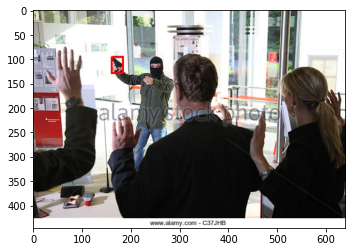

In [25]:
!pwd

# for first time:
# ---------------
# annotations = os.listdir('annotations')
# annotations.sort()
# # print('annotations: ', annotations)
# images = os.listdir('images')
# images.sort()
# # print('images: ', images)
# ---------------

# for second time and on:
# ---------------
train_annotations = os.listdir('datasets/coco/labels/train')
train_annotations.sort()
train_images = os.listdir('datasets/coco/images/train')
train_images.sort()
# ---------------


class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)), outline ="red", width = 4)     # fill ="#ffff33"
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()


# Get any random annotation file 
annotation_file = random.choice(train_annotations)
print('short annotation file:', annotation_file)
annotation_file = os.path.join('datasets/coco//labels/train', annotation_file)
# print('long annotation file:', annotation_file)

with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    # print('annotation file content:', annotation_list)
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("labels", "images").replace("txt", "jpg")
print('image file:', image_file)
# assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)
# image.show()
#Plot the Bounding Box
plot_bounding_box(image, annotation_list)


# Data split and re-organize

In [26]:
# Read images and annotations

# images = [x for x in os.listdir('images') if x[-3:] == "jpg"]
# annotations = [x for x in os.listdir('annotations') if x[-3:] == "txt"]


# option a: Split the dataset into train-valid-test splits - for first split (all in the same directory)
# --------------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------------
# images = [os.path.join('images', x) for x in os.listdir('images') if x[-3:] == 'jpg']
# annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "txt"]

# images.sort()
# annotations.sort()

# # print(images)
# # print(annotations)

# print(len(images))
# print(len(annotations))

# train_images, test_images, train_annotations, test_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
# val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

# --------------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------------





# option b: Split the dataset - if already split into separate directories:
# --------------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------------

train_images = [os.path.join('datasets/coco/images/train', x) for x in os.listdir('datasets/coco/images/train')  if x[-3:] == 'jpg']
test_images = [os.path.join('datasets/coco/images/test', x) for x in os.listdir('datasets/coco/images/test')  if x[-3:] == 'jpg']
train_annotations = [os.path.join('datasets/coco/labels/train', x) for x in os.listdir('datasets/coco/labels/train') if x[-3:] == "txt"]
test_annotations = [os.path.join('datasets/coco/labels/test', x) for x in os.listdir('datasets/coco/labels/test')if x[-3:] == "txt"]

train_images.sort()
test_annotations.sort()
train_annotations.sort()
test_images.sort()

print(len(train_images), 'train images: ', train_images)
print(len(train_annotations), 'train_annotations: ', train_annotations)
print(len(test_images),'test images: ', test_images)
print(len(test_annotations), 'test_annotations: ', test_annotations)


# --------------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------------

2399 train images:  ['datasets/coco/images/train/armas (1).jpg', 'datasets/coco/images/train/armas (10).jpg', 'datasets/coco/images/train/armas (100).jpg', 'datasets/coco/images/train/armas (1002).jpg', 'datasets/coco/images/train/armas (1004).jpg', 'datasets/coco/images/train/armas (1005).jpg', 'datasets/coco/images/train/armas (1006).jpg', 'datasets/coco/images/train/armas (1008).jpg', 'datasets/coco/images/train/armas (1009).jpg', 'datasets/coco/images/train/armas (1010).jpg', 'datasets/coco/images/train/armas (1011).jpg', 'datasets/coco/images/train/armas (1012).jpg', 'datasets/coco/images/train/armas (1014).jpg', 'datasets/coco/images/train/armas (1015).jpg', 'datasets/coco/images/train/armas (1016).jpg', 'datasets/coco/images/train/armas (1017).jpg', 'datasets/coco/images/train/armas (1018).jpg', 'datasets/coco/images/train/armas (1019).jpg', 'datasets/coco/images/train/armas (102).jpg', 'datasets/coco/images/train/armas (1020).jpg', 'datasets/coco/images/train/armas (1021).jpg',

In [27]:
# !mkdir images/train images/test annotations/train annotations/test

In [28]:
#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        print(f)
        try:
            shutil.move(f, destination_folder)
        except:
            print(f, 'failed')
            assert False


In [29]:
# # Move the splits into their folders

# move_files_to_folder(train_images, 'images/train')
# move_files_to_folder(train_annotations, 'annotations/train/')
# move_files_to_folder(test_images, 'images/test/')
# move_files_to_folder(test_annotations, 'annotations/test/')

# Dataset class definition

In [456]:
class Weapon_Dataset(Dataset):
    
    def __init__(self, image_path, Transform=None):
      self.image_path = image_path
      self.transform = Transform
      self.image_list = [x for x in os.listdir(self.image_path) if x[-3:] == "jpg"]
      self.image_list.sort()
      self.label_path = self.image_path.replace("images","labels")
      self.label_list = [x for x in os.listdir(self.label_path) if x[-3:] == "txt"]
      self.label_list.sort()

      print('WEAPON DATASET INTIALIZED')
      print('image list: ', self.image_list)
      print('label list: ', self.label_list)

    def __len__(self):
      return len(self.image_list)
    
    def __getitem__(self, idx): 
      print('NEW GET_ITEM')
      # if torch.is_tensor(idx):
        # idx = idx.tolist()
      print('this is idx: ', idx)
      

      print('FOR TESTING: manual override - idx = 1698 (has two labels)')
      idx = 1698


    # read image:
      image = Image.open(self.image_path + '/' + self.image_list[idx]).convert('RGB')        
      print('image :', self.image_path, '/', self.image_list[idx])
      print('image size is: ', np.shape(image))
      


    # read label:
      # define file
      label_file = self.label_list[idx]
      print('label file: ', label_file)
      full_label_path = self.label_path + '/' + label_file
      print('full label path: ', full_label_path)
      
      # open file
      with open(full_label_path, "r") as file:
        # print('label before line: ', file)
        label = file.read().split("\n")[:-1]
      print('label from file: ', label)
      print(type(label))
      
      # convert to numbers
      print('converting label to numbers:')  
      numbered_labels = np.empty((5))
      for i in range(len(label)):
        print('iteration ', i)
        
        print('SPLIT:')
        float_label = label[i].split()
        print('float label type: ', type(float_label))

        print('CONVERT TO NP ARRAY:')
        float_label = np.array(float_label,dtype=np.float)
        print('float label: ', float_label)
        print('float label type: ', type(float_label))
        print(np.shape(float_label))

        print('STACKING')
        numbered_labels = np.stack((numbered_labels,float_label))
        print('numbered labels so far: ', numbered_labels)
      
      
      # # [float(i) for i in label]
      # print('converted label to ', type(label), '(make sure list of floats)')
      # print(label)
      # print(np.shape(label))      
      # label = np.asarray(label)
      # label = label.astype(float)
      # print('converted label to ', type(label), '(make sure np.array)')
      # print(label)
      # print(np.shape(label))

      # train_y = torch.tensor(label)

        # for i in range(len(label)):
        #   print('iteration ', i)
        #   train_y = torch.tensor(label[i])
        # print('train_y: ', train_y)
        # print(type(train_y))

      return self.transform(image), train_y

## TODO - TWO PROBLEMS:
# 1. HOW DO WE CONVERT AND SEND LABELS BACK AS A TENSOR
# 2. HOW DO WE DEAL WITH MULTIPLE DETECTIONS IN AN IMAGE? (BOTH IN ARRANGING THE 
#    VARIABLE AND THE DIFFERENT SIZE OF LABELS BETWEEN IMAGES IN A BATCH)


# # -------------------------------------# -------------------------------------
# # -------------------------------------# -------------------------------------
# # -------------------------------------# -------------------------------------
# class Cassava_Dataset(Dataset):
    
#     def __init__(self, image_path,csv_file, Transform=None):
#         self.image_path = image_path
#         self.csv = pd.read_csv(csv_file) 
#         self.transform = Transform
        
#     def __len__(self): 
#       return len(self.csv)
    
#     def __getitem__(self, idx): 
#       if torch.is_tensor(idx):
#         idx = idx.tolist()
       
#       image = Image.open(os.path.join(self.image_path, self.csv.iloc[idx,0]))
#       label = self.csv.iloc[idx,1]
#         #if self.image_path == '../input/cassava-leaf-disease-classification/train_images':
#       return self.transform(image), label

## Initialize:
# image_path = "/content/dataset"
# train_dataset = Cassava_Dataset(image_path,train_csv,train_transform)



In [457]:
from torch.utils.data import Dataset, DataLoader

default_transform =  transforms.Compose([transforms.ToTensor(),
                                         transforms.Resize([416, 416]),
                                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                         ])


train_image_path = 'datasets/coco/images/train'
train_dataset = Weapon_Dataset(image_path = train_image_path, Transform = default_transform)
test_image_path = 'datasets/coco/images/test'
test_dataset = Weapon_Dataset(image_path = test_image_path, Transform = default_transform)

batch_size = 1

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size ,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size ,shuffle=True)


WEAPON DATASET INTIALIZED
image list:  ['armas (1).jpg', 'armas (10).jpg', 'armas (100).jpg', 'armas (1002).jpg', 'armas (1004).jpg', 'armas (1005).jpg', 'armas (1006).jpg', 'armas (1008).jpg', 'armas (1009).jpg', 'armas (1010).jpg', 'armas (1011).jpg', 'armas (1012).jpg', 'armas (1014).jpg', 'armas (1015).jpg', 'armas (1016).jpg', 'armas (1017).jpg', 'armas (1018).jpg', 'armas (1019).jpg', 'armas (102).jpg', 'armas (1020).jpg', 'armas (1021).jpg', 'armas (1022).jpg', 'armas (1024).jpg', 'armas (1025).jpg', 'armas (1026).jpg', 'armas (1027).jpg', 'armas (1028).jpg', 'armas (1029).jpg', 'armas (103).jpg', 'armas (1030).jpg', 'armas (1031).jpg', 'armas (1032).jpg', 'armas (1033).jpg', 'armas (1036).jpg', 'armas (1037).jpg', 'armas (1038).jpg', 'armas (104).jpg', 'armas (1041).jpg', 'armas (1042).jpg', 'armas (1044).jpg', 'armas (1045).jpg', 'armas (1046).jpg', 'armas (1048).jpg', 'armas (1049).jpg', 'armas (105).jpg', 'armas (1051).jpg', 'armas (1052).jpg', 'armas (1053).jpg', 'armas (10

In [458]:
# !pwd
# %cd yolov5
# !python train.py --img 640 --batch 16 --epochs 3 --data train_file.yaml --weights yolov5s.pt

In [459]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=25):
  since = time.time()
  val_acc_history = []
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)
    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
      if phase == 'train':
        print('train phase')
        model.train() # Set model to training mode
      else:
        print('test phase')
        model.eval() # Set model to evaluate mode
      print('initializing loss')
      running_loss = 0.0
      running_corrects = 0
      # Iterate over data.
      for inputs, labels in train_loader:
      # for inputs, labels in enumerate(train_loader, 0):

        print('BATCH LOADED')
        print('inputs: ', inputs)
        print('labels: ', labels)
        # inputs = inputs.to(device)
        # labels = labels.to(device)
        print('shape of inputs is: ', inputs.size())
        print('shape of labels is: ', len(labels))

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
          # Get model outputs and calculate loss
          outputs = model(inputs)
          print('OUTPUT: ', outputs)
          print(type(outputs))
          loss = criterion(outputs, labels)
          _, preds = torch.max(outputs, 1)
          # backward + optimize only if in training phase
          if phase == 'train':
            # zero the parameter gradients
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
      epoch_loss = running_loss / len(dataloaders[phase].dataset)
      epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
      # deep copy the model
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
      if phase == 'val':
        val_acc_history.append(epoch_acc)
    print()
  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))
  # load best model weights
  model.load_state_dict(best_model_wts)
  return model, val_acc_history

In [460]:
# SCRIPT + ROBOFLOW TRAINING:

# !python yolov5/train.py --img 640 --cfg yolov5s.yaml --hyp yolov5/data/hyp.scratch.yaml --batch 32 --epochs 2 --data yolov5/data/weapon_data.yaml --weights yolov5s.pt --workers 24 --name weapon_det


In [461]:
# Setup the loss fn


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
params_to_update = model.parameters()
criterion = nn.CrossEntropyLoss()
optimizer_ft = torch.optim.SGD(params_to_update, lr=0.001, momentum=0.9)
num_epochs = 2
model, hist = train_model(model, train_loader, criterion, optimizer_ft, num_epochs=num_epochs)
# Train and evaluate

Epoch 0/1
----------
train phase
initializing loss
NEW GET_ITEM
this is idx:  468
FOR TESTING: manual override - idx = 1698 (has two labels)
image : datasets/coco/images/train / armas (291).jpg
image size is:  (300, 1200, 3)
label file:  armas (291).txt
full label path:  datasets/coco/labels/train/armas (291).txt
label from file:  ['0 0.150 0.863 0.136 0.273', '0 0.427 0.410 0.203 0.387']
<class 'list'>
converting label to numbers:
iteration  0
SPLIT:
float label type:  <class 'list'>
CONVERT TO NP ARRAY:
float label:  [          0        0.15       0.863       0.136       0.273]
float label type:  <class 'numpy.ndarray'>
(5,)
STACKING
numbered labels so far:  [[4.6686e-310 4.6686e-310           0           0 4.6686e-310]
 [          0        0.15       0.863       0.136       0.273]]
iteration  1
SPLIT:
float label type:  <class 'list'>
CONVERT TO NP ARRAY:
float label:  [          0       0.427        0.41       0.203       0.387]
float label type:  <class 'numpy.ndarray'>
(5,)
STACK

ValueError: ignored